#Intro

In this demo, we construct a RNN that will learn to output piano music after being trained on a number of piano compositions in the MIDI file format.

In [1]:
!sudo apt install -y fluidsynth
!pip install --upgrade pyfluidsynth
!pip install pretty_midi

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  fluid-soundfont-gm libfluidsynth1 libqt5x11extras5 qsynth
Suggested packages:
  fluid-soundfont-gs timidity jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libfluidsynth1 libqt5x11extras5 qsynth
0 upgraded, 5 newly installed, 0 to remove and 42 not upgraded.
Need to get 120 MB of archives.
After this operation, 150 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fluid-soundfont-gm all 3.1-5.1 [119 MB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libfluidsynth1 amd64 1.1.9-1 [137 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fluidsynth amd64 1.1.9-1

In [2]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple

In [3]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
#Sampling Rate for Audio Playback
_SAMPLING_RATE = 16000

#Data

This RNN can be trained on any number of MIDI files but, for the sake of brevity, we have uploaded 10 to use as data for this demo.

In [4]:
#Import Data
data_dir = pathlib.Path("data/example_midi_data")
!wget -O data.zip https://www.dropbox.com/s/vho3um36lpwmdri/example_midi_data.zip?dl=0
!unzip -d data data.zip 
#data_dir = pathlib.Path("data/maestro-v2.0.0")
#if not data_dir.exists():
  #tf.keras.utils.get_file('maestro-v2.0.0-midi.zip', origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip', extract=True, cache_dir='.', cache_subdir='data')

--2022-05-02 04:00:38--  https://www.dropbox.com/s/vho3um36lpwmdri/example_midi_data.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/vho3um36lpwmdri/example_midi_data.zip [following]
--2022-05-02 04:00:39--  https://www.dropbox.com/s/raw/vho3um36lpwmdri/example_midi_data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce8ca2a9456b15e841c82e488c2.dl.dropboxusercontent.com/cd/0/inline/Bkf6WnwvwcBH60KHksgR-S3jjU6r1UEeeQr6K6W1_3E6meiUAKVrLVLlB9utwRrB6A0ynuus29-clDD0EMEAquVZAz3ZpxPqn4Au_rLuDAMBBMczXuAOn83cl0zOxpP_69gw38ZQykyzMK1B_V0xRpTm0VoBgFPeLbLi-Pg1E7FHtg/file# [following]
--2022-05-02 04:00:39--  https://uce8ca2a9456b15e841c82e488c2.dl.dropboxusercontent.com/cd/0/inline/Bkf6WnwvwcBH60KHksgR-S3jjU6r1UEeeQr6

In [5]:
filenames = glob.glob(str(data_dir/"*.mid"))
print("Number of Files:", len(filenames))

Number of Files: 10


In [6]:
sample_file = filenames[1]
print(sample_file)

data/example_midi_data/song6.mid


In [7]:
pm = pretty_midi.PrettyMIDI(sample_file)

#Helper Functions

There are a number of helper functions that are necessary for this method of neural net music generation to operate. Some coming from python packages and some coming courtesy of TensorFlow, they allow us to do things like convert MIDI files to our input data and vice-versa, display the music in piano roll form, generate notes with the trained model, among others.

In [8]:
#Display Audio
def display_audio(pm: pretty_midi.PrettyMIDI, seconds = 30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  #Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [9]:
#display_audio(pm)

In [10]:
print("Number of Instruments:", len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print("Instrument Name:", instrument_name)

Number of Instruments: 2
Instrument Name: Acoustic Grand Piano


In [11]:
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f"{i}: pitch={note.pitch}, note_name={note_name}," f"duration={duration:.4f}")

0: pitch=90, note_name=F#6,duration=0.0862
1: pitch=94, note_name=A#6,duration=0.0862
2: pitch=85, note_name=C#6,duration=0.0862
3: pitch=90, note_name=F#6,duration=0.0862
4: pitch=87, note_name=D#6,duration=0.0862
5: pitch=90, note_name=F#6,duration=0.0862
6: pitch=85, note_name=C#6,duration=0.0862
7: pitch=90, note_name=F#6,duration=0.0862
8: pitch=82, note_name=A#5,duration=0.0862
9: pitch=85, note_name=C#6,duration=0.0862


In [12]:
#Midi To Notes
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  #sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

#Data Format

The MIDI-To-Notes converts a midi file into the data we are training the net on. It converts each note into three separate values; pitch, step, and duration. The pitch represents the frequency of the sound, the step is the amount of time that has passed since the last played note, and the duration is how long the note sounds out for.

In [13]:
#Notes by Pitch
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,90,0.001078,0.087284,0.000000,0.086207
1,94,0.086207,0.172414,0.085129,0.086207
2,85,0.172414,0.258621,0.086207,0.086207
3,90,0.258621,0.344827,0.086207,0.086207
4,87,0.344827,0.431034,0.086207,0.086207


In [14]:
#Notes by Note
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes["pitch"])
sample_note_names[:10]

array(['F#6', 'A#6', 'C#6', 'F#6', 'D#6', 'F#6', 'C#6', 'F#6', 'A#5',
       'C#6'], dtype='<U3')

In [15]:
#Plotting
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

In [16]:
#plot_piano_roll(raw_notes, count=100)

In [17]:
#plot_piano_roll(raw_notes)

In [18]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

In [19]:
#plot_distributions(raw_notes)

In [20]:
#Create MIDI File
def notes_to_midi(notes: pd.DataFrame, out_file: str, instrument_name: str, velocity: int = 100) -> pretty_midi.PrettyMIDI:
  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(program=pretty_midi.instrument_name_to_program(instrument_name))
  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(velocity=velocity, pitch=int(note['pitch']), start=start, end=end)
    instrument.notes.append(note)
    prev_start = start
  #Multiple Instruments Add Below To Loop?
  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [21]:
#example_file = 'example.midi'
#example_pm = notes_to_midi(raw_notes, out_file=example_file, instrument_name=instrument_name)
#display_audio(example_pm)

In [22]:
#Create Training Dataset
num_files = 10
all_notes = []
for f in filenames[0:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

n_notes = len(all_notes)
print("Number of Parsed Notes:", n_notes)

Number of Parsed Notes: 6594


In [23]:
#Create Dataset from Notes
key_order = ["pitch", "step", "duration"]
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

#Sequences

The network is trained on sequences of notes, followed by a "next note" so that, given a sequence, it has a better idea of what the next pitch, step, and duration should be.

In [24]:
#Create Sequences so Net Will Train to Predict Next Note in Sequence
def create_sequences(dataset: tf.data.Dataset, seq_length: int, vocab_size = 128) -> tf.data.Dataset:
  #Returns TF Dataset of sequence and label examples
  seq_length = seq_length+1
  #Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1, drop_remainder=True)
  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)
  #Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x
  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}
    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [25]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'duration': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [26]:
for seq, target in seq_ds.take(1):
  print("Sequence Shape:", seq.shape)
  print("Sequence Elements (First 10):", seq[0:10])
  print()
  print("Target:", target)

Sequence Shape: (25, 3)
Sequence Elements (First 10): tf.Tensor(
[[0.2265625  0.         0.046875  ]
 [0.3203125  0.         0.046875  ]
 [0.46875    0.         0.05729167]
 [0.4140625  0.00520833 0.046875  ]
 [0.4453125  0.015625   0.0625    ]
 [0.453125   0.296875   0.125     ]
 [0.265625   0.         0.734375  ]
 [0.4140625  0.00520833 0.05208333]
 [0.4765625  0.         0.11458333]
 [0.359375   0.         0.67708333]], shape=(10, 3), dtype=float64)

Target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=65.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.010416666666666519>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.07291666666666674>}


In [27]:
#Batch Examples and Configure Dataset for Performance
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds.shuffle(buffer_size).batch(batch_size, drop_remainder=True).cache().prefetch(tf.data.experimental.AUTOTUNE))
train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

In [28]:
#Create And Train Model

#Encourage Model to Output Positive Values
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

#Architecture

Numerous architectures were tested, including different amounts of stacked LSTM units, GRU units, an RNN with LSTM layers separated by residual blocks, and even a far more simple feed-forward net with dense layers. Our peak performance was achieved with just 2 stacked LSTM layers as you see below.

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 25, 3)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 25, 256)      266240      ['input_1[0][0]']                
                                                                                                  
 lstm_1 (LSTM)                  (None, 256)          525312      ['lstm[0][0]']                   
                                                                                                  
 duration (Dense)               (None, 1)            257         ['lstm_1[0][0]']                 
                                                                                              

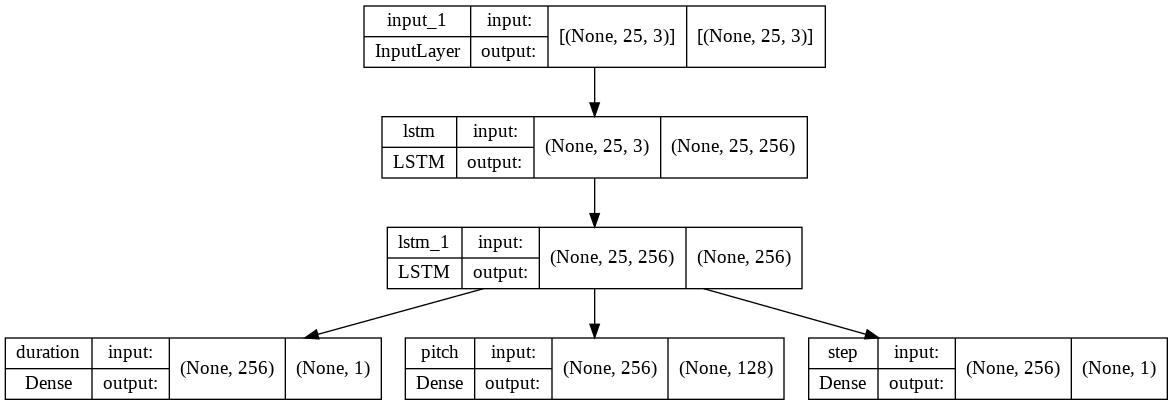

In [29]:
#Build & Compile Model
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(256, return_sequences=True)(inputs)
x = tf.keras.layers.LSTM(256)(x)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(loss=loss, optimizer=optimizer)
model.summary()
tf.keras.utils.plot_model(model,show_shapes=True,expand_nested=True)

In [30]:
losses = model.evaluate(train_ds, return_dict=True)
losses

102/102 [==============================] - 9s 12ms/step - loss: 5.4859 - duration_loss: 0.2524 - pitch_loss: 4.8536 - step_loss: 0.3798


{'duration_loss': 0.2524350881576538,
 'loss': 5.48585319519043,
 'pitch_loss': 4.8536224365234375,
 'step_loss': 0.3797950744628906}

In [31]:
model.compile(loss=loss, loss_weights={'pitch': 0.05, 'step': 1.0, 'duration':1.0}, optimizer=optimizer)
model.evaluate(train_ds, return_dict=True)

102/102 [==============================] - 3s 5ms/step - loss: 0.8749 - duration_loss: 0.2524 - pitch_loss: 4.8536 - step_loss: 0.3798


{'duration_loss': 0.2524350881576538,
 'loss': 0.8749111294746399,
 'pitch_loss': 4.8536224365234375,
 'step_loss': 0.3797950744628906}

In [32]:
#Train Model
callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath='./training_checkpoints/ckpt_{epoch}', save_weights_only=True), tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1, restore_best_weights=True)]

In [33]:
%%time
epochs = 75
#history = model.fit(train_ds, epochs=epochs, callbacks=callbacks)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.15 µs


In [34]:
#Load Pre-Trained Weights
!wget -O weightsRNN.zip https://www.dropbox.com/s/zhuzqmjicbkdunv/weightsRNN.zip?dl=0
!unzip weightsRNN.zip
model.load_weights("weightsRNN/weights")
#model.save_weights("./weightsRNN/weights")

--2022-05-02 04:00:58--  https://www.dropbox.com/s/zhuzqmjicbkdunv/weightsRNN.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/zhuzqmjicbkdunv/weightsRNN.zip [following]
--2022-05-02 04:00:59--  https://www.dropbox.com/s/raw/zhuzqmjicbkdunv/weightsRNN.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf187e8a803a1070dfe1f074068.dl.dropboxusercontent.com/cd/0/inline/Bkeq-yuiMj7g2gcPOkvgTePmHJw6vZvh33qphYtweJ3oa-BVggJXUkyp8i4GvH9IbSfnZiGU-vzKJa8ESGh2Hv4Ph07YvE7tZAS4VpAJKke_nmP418VFwARhXpvFix7N2sG3wVNc_i0S40w2MIcfCUnSshSV4nxc09mknFpd9besgA/file# [following]
--2022-05-02 04:00:59--  https://ucf187e8a803a1070dfe1f074068.dl.dropboxusercontent.com/cd/0/inline/Bkeq-yuiMj7g2gcPOkvgTePmHJw6vZvh33qphYtweJ3oa-BVggJXUkyp8

In [35]:
#Plot
#plt.plot(history.epoch, history.history['loss'], label='total loss')
#plt.show()

In [36]:
#Generate Notes Definition
def predict_next_note(notes: np.ndarray, keras_model: tf.keras.Model, temperature: float = 1.0) -> int:
  #Generates Note ID's Using a Trained Sequence Model

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

#Note Generation

Next we allow the net to generate its own music. The network will produce what it thinks the next pitch, step, and duration should be, and the helper function will convert these values into a playable MIDI file.

In [37]:
#Generate Notes
temperature = 2.0
num_predictions = 200

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(generated_notes, columns=(*key_order, 'start', 'end'))

In [38]:
generated_notes.head(10)

,pitch,step,duration,start,end
0,66,0.157451,0.094452,0.157451,0.251904
1,84,0.294596,0.291692,0.452047,0.743738
2,91,0.430892,0.249694,0.882938,1.132633
3,91,0.444263,0.152800,1.327202,1.480002
4,89,0.431371,0.209099,1.758573,1.967672
5,99,0.478914,0.184712,2.237486,2.422199
6,91,0.472277,0.208470,2.709763,2.918233
7,92,0.482377,0.207807,3.192140,3.399947
8,88,0.483128,0.214021,3.675268,3.889289
9,87,0.483734,0.216149,4.159002,4.375152


In [39]:
out_file = 'output.mid'
out_pm = notes_to_midi(generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

In [40]:
#Download
from google.colab import files
#files.download(out_file)
#files.download("weightsRNN.zip")

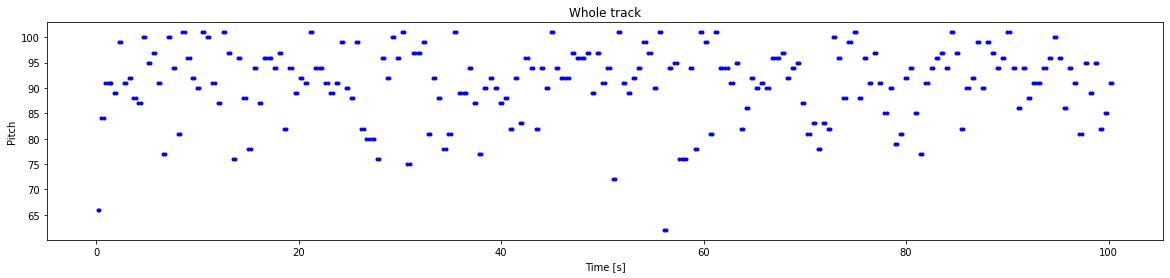

In [41]:
#Plots
plot_piano_roll(generated_notes)

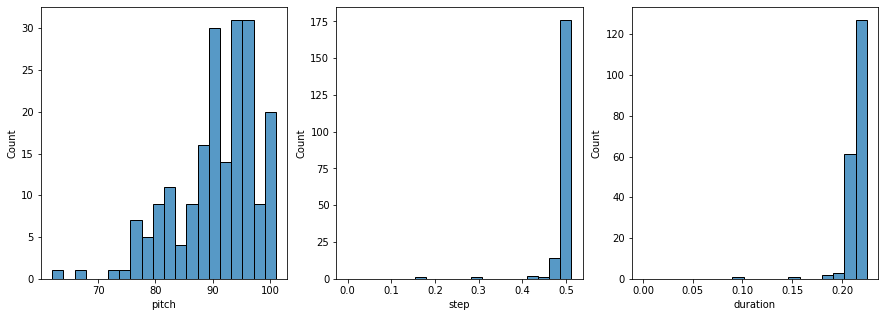

In [42]:
plot_distributions(generated_notes)